```{currentmodule} tskit
```

(sec_phylogen)=

# `Tskit` for phylogenetics

`Tskit`, the tree sequence toolkit, can be used as an efficient library for very large evolutionary trees. `Tskit` makes it easy to deal with trees with millions of
tips, as in the example below:

In [1]:
import tskit

In [2]:
%%time

num_tips = 1_000_000
big_tree = tskit.Tree.generate_comb(num_tips);
print("Tree sequence takes up", big_tree.tree_sequence.nbytes / 1024**2, "Mb")
print(f"Generating a 'comb' (pectinate) tree of {num_tips} tips took:")

Tree sequence takes up 129.70017337799072 Mb
Generating a 'comb' (pectinate) tree of 1000000 tips took:
CPU times: user 6.27 s, sys: 168 ms, total: 6.44 s
Wall time: 6.44 s


:::{todo}
Display the million tip tree in condensed form, when
https://github.com/tskit-dev/tskit/issues/2372#issuecomment-1298518380 and
https://github.com/tskit-dev/tskit/issues/2628 are solved
:::

Calculations on these huge trees can be very efficient:

In [3]:
%%time

traversed_nodes = 0
for u in big_tree.nodes(order="postorder"):
    traversed_nodes += 1
print(f"Postorder traversal through {traversed_nodes} nodes took:")

Postorder traversal through 1999999 nodes took:
CPU times: user 374 ms, sys: 44 µs, total: 374 ms
Wall time: 374 ms


In [4]:
%%time

b1_index = big_tree.b1_index()
print(f"B1 balance index is {b1_index}. Calculation took:")

B1 balance index is 14.39272472286399. Calculation took:
CPU times: user 14.4 ms, sys: 0 ns, total: 14.4 ms
Wall time: 14.4 ms


We can also read trees efficiently, e.g. in Newick format:

:::{todo}
Add example of fast reading of a newick file, once
https://github.com/tskit-dev/tskit/issues/2187 is solved. E.g. we could say
> For example, we can read in a newick format tree of XXX tips in XXX secs. In practice,
> this means when reading in a large tree you are mainly limited by disk access speeds
:::

In [5]:
import tsconvert  # used for reading tree sequences from different formats

# example code reading in a large file, timed

# Or read smaller trees from strings (here we create a tree spanning 1000 genomic units)
# Todo: add sequence length: https://github.com/tskit-dev/tsconvert/issues/40
ts = tsconvert.from_newick("(A:6,((B:1,C:1):2,(D:2,E:2):1):3);", span=100)

The "succinct tree sequence" format used by `tskit` can also store mutations
(and optionally a reference genome) along with the tree(s). This results in a
single unified representation of large genomic datasets, storing trees,
sequence data and metadata in a single efficient structure. Examples are given
in the section below entitled {ref}`sec_phylogen_unified_structure`.

As the name suggests, a tree sequence can also store and analyse a sequence of
trees along a genome (i.e. a "phylogenetic network"). This is necessary to
account for recombination between lineages, and may be important even when looking at
species-level phylogenies due to the effects of hybridization and incomplete lineage
sorting. An overview, and links to further details are given at the
{ref}`end of this page <sec_phylogen_multiple_trees>`.

## Hints for phylogeneticists

Unlike other phylogenetic libraries, `tskit` is designed to efficiently store not just 
single trees, but sequences of correlated trees along a genome. This means that the
library has some features not found in more standard phylogenetic libraries.
Here we focus on the {ref}`sec_python_api`,
introducing eight `tskit` concepts that may be useful to those with a background in
phylogenetics (each is linked to a separate section below):

1. An evolutionary tree is always contained within a "tree sequence".
   See {ref}`sec_phylogen_tree_in_sequence`
2. The basic elements of a tree are *nodes* and *edges*, referred to by integer IDs.
   See {ref}`sec_phylogen_ids`
3. The `Tree` object in the Python API provides useful phylogenetic methods.
   See {ref}`sec_phylogen_tree_object`
4. Specific nodes in a tree (often the tips) are marked as "samples", meaning they are
   known from data. See {ref}`sec_phylogen_samples`
5. Nodes and edges have additional attributes, with arbitrary information stored in
   *metadata*. See {ref}`sec_phylogen_metadata`
6. All nodes *must* have a valid time, meaning trees are always directional
   (i.e. "rooted"). See {ref}`sec_phylogen_node_time`
7. "Roots" in trees have a specific definition, and a single tree can consist of
   topologically independent clades (a "multiroot" tree).
   See {ref}`sec_phylogen_multiroot`

(sec_phylogen_tree_in_sequence)=
### Trees are always part of a tree sequence

In tskit, all trees are stored as a "tree sequence" of correlated trees. This allows
easy extension of the library to multiple trees produced e.g. by hybridization.
In the simplest case, however, the tree sequence can contain just a single tree. This
can be obtained using the {meth}`~TreeSequence.first()` method.

In [6]:
# Make sensible node labels. It would be nice to roll this into tree.draw()
node_labels = {
    node_object.id: node_object.metadata["name"]
    for node_object in ts.nodes()
    if "name" in node_object.metadata
}

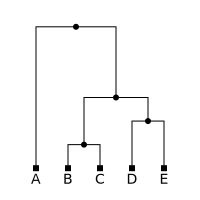

In [7]:
tree = ts.first()
tree.draw(node_labels=node_labels)  # or use draw_svg() for more options

Often you will have the tree sequence stored in a variable, such as the `ts` variable
used above. However, you can also obtain the tree sequence in which a tree is
contained using the {attr}`Tree.tree_sequence` attribute:

In [8]:
tree.tree_sequence  # When output in a notebook, prints a summary of the tree sequence

(sec_phylogen_ids)=
### Integer node and edge IDs

The plot above labels nodes by their name, but internally the `tskit` library relies
heavily on integer IDs. Here's the same tree with node IDs plotted instead:

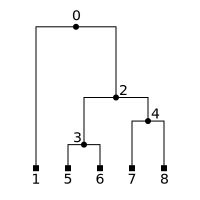

In [9]:
tree = ts.first()
tree.draw_svg()

#### Nodes

Each {ref}`node<sec_terminology_nodes>` in a tree sequence is allocated an
integer ID starting from 0 to `ts.num_nodes - 1` (IDs can be allocated in any order;
often the tips are labelled starting from 0 but this is not necessarily so, and
is not the case in the example above).

For efficiency reasons, tree traversal routines, as well as many other `tskit` methods,
tend to return integer IDs. You can use this ID to get specific information about the
node and its position in the tree, for example

In [10]:
node_id = 4
parent_id = tree.parent(node_id)
child_ids = tree.children(node_id)
print("The parent of", node_id, "is", parent_id, "and its children are", child_ids)
# or e.g. get all parents them as an array (where -1 means there is no parent)
print(f"The parents of nodes 0..{ts.num_nodes-1} are", tree.parent_array)

The parent of 4 is 2 and its children are (7, 8)
The parents of nodes 0..8 are [-1  0  0  2  2  3  3  4  4 -1]


Other methods also exist to
{ref}`examine nodes in a tree<sec_python_api_trees_node_measures>`, e.g.
{meth}`Tree.is_leaf`, {meth}`Tree.mrca` for the most recent common ancestor between
2 or more nodes, etc.

#### Edges

Rather than refer to "branches" of a tree, tskit tends to refer to
{ref}`sec_terminology_edges` (the term "edge" emphasises that these can span
{ref}`sec_phylogen_multiple_trees`, although for tree sequences containing a single
tree, the terms are interchangeable). Like other entities in `tskit`, edges are referred
to by an integer ID. For instance, here is the edge above the internal node 4

In [11]:
node_id = 4
edge_id = tree.edge(node_id)
print("The edge above", node_id, "has ID", edge_id)
print(tree.tree_sequence.edge(edge_id))

The edge above 4 has ID 5
Edge(left=0.0, right=100.0, parent=2, child=4, metadata=b'', id=5)


The `left` and `right` attributes of an edge give genomic coordinates, and are
important in tree sequences that contain more than one tree.


(sec_phylogen_tree_object)=
### The `Tree` object

The {class}`Tree` object has {ref}`methods<sec_python_api_trees>` to perform basic operations
on a tree such as traversing the nodes, identifying parents, children, and common
ancestors, etc. {ref}`Several methods<sec_python_api_trees_node_measures_array>`
also return numpy arrays for use in
{ref}`efficient algorithms using numba<sec_trees_numba>`

In [12]:
for n_id in tree.nodes(order="postorder"):
    # you can also use "preorder", "levelorder", "timeasc", etc.
    print(n_id)
# Or get all of them as arrays
print("Node IDs in postorder:", tree.postorder())

1
5
6
3
7
8
4
2
0
Node IDs in postorder: [1 5 6 3 7 8 4 2 0]


Various phylogenetic statistics are also available on trees, e.g

In [13]:
print(f"The colless imbalance index is {tree.colless_index()}")

The colless imbalance index is 3


See {ref}`sec_phylogen_methods` for more examples.

(sec_phylogen_samples)=
### Sample nodes

Often we are only have detailed information about specific nodes that we have sampled,
such as genomes A, B, C, D, and E in the example above. These are designated as
*sample nodes*, and are plotted as square nodes. The concept of
{ref}`sample nodes<sec_data_model_definitions_sample>` is integral
to the `tskit` format. They can be identified by using the
{meth}`Node.is_sample` and {meth}`Tree.is_sample` methods, or can be listed using
{meth}`TreeSequence.samples` or {meth}`Tree.samples()` (internally, the `node.flags`
field is used to {ref}`flag up<sec_node_table_definition>` which nodes are samples):

In [14]:
for n_id in tree.nodes():
    n_is_sample = tree.is_sample(n_id)
    print(f"Node {n_id} {'is' if n_is_sample else 'is not'} a sample node")

print("Sample nodes are", tree.tree_sequence.samples())

Node 0 is not a sample node
Node 1 is a sample node
Node 2 is not a sample node
Node 3 is not a sample node
Node 5 is a sample node
Node 6 is a sample node
Node 4 is not a sample node
Node 7 is a sample node
Node 8 is a sample node
Sample nodes are [1 5 6 7 8]


Often the sample nodes are the leaves of a tree, but this need not be the case. There
are fast methods for identifying the sample nodes under an internal node in the tree,
etc.


(sec_phylogen_metadata)=
### Attributes and metadata

Given a node ID, you can access more information about the node from a
{class}`node object<tskit.Node>`.
Because nodes are shared across all trees in a tree sequence, you access the
node object via the `tree_sequence` to which this tree belongs:

In [15]:
tree.tree_sequence.node(node_id)  # or simply ts.node(node_id)

Node(id=4, flags=0, time=2.0, population=-1, individual=-1, metadata={})

Attributes such as `id`, `flags` and `time` are always present. Arbitrary information,
such a name or e.g. bootstrap values, are stored in *metadata*

In [16]:
for n_id in tree.nodes():
    print("Node", n_id, tree.tree_sequence.node(n_id).metadata.get("name", "<no name>"))

Node 0 <no name>
Node 1 A
Node 2 <no name>
Node 3 <no name>
Node 5 B
Node 6 C
Node 4 <no name>
Node 7 D
Node 8 E


However, for large datasets, it may be more efficient to access the array of e.g.
times for all nodes, which provides direct memory access into the
{ref}`tables<sec_tables>` that underlie the tree sequence format:

In [17]:
tree.tree_sequence.nodes_time

array([6., 0., 3., 1., 2., 0., 0., 0., 0.])

(sec_phylogen_node_time)=
### Nodes must have times

Perhaps the most noticable different between a `tskit` tree and the encoding of trees
in other phylogenetic libraries is that `tskit` does not explicitly store branch lengths.
Instead, each node has a *time* associated with it. Branch lengths can therefore be
found by calculating the difference between the time of a node and the time of its
parent node.

Since nodes *must* have a time, `tskit` trees aways have these (implicit) branch
lengths. To represent a tree ("cladogram") in which the branch lengths are not
meaningful, the {attr}`TreeSequence.time_units` of a tree sequence can be
specified as `"uncalibrated"` (see below)

Another implication of storing node times rather than branch lengths is that `tskit`
trees are always directional (i.e. they are "rooted"). The reason that `tskit` stores
times of nodes (rather than e.g. genetic distances between them) is to ensure temporal 
consistency. In particular it makes it impossible for a node to be an ancestor of a
node in one tree, and a descendant of the same node in another tree in the tree sequence.
This is of critical importance when extending the concept of genetic ancestry to
{ref}`sec_phylogen_multiple_trees` along a genome.

The {attr}`TreeSequence.time_units` attribute stores the units in which time is
measured: if not known, this defaults to "unknown":

Time units are unknown


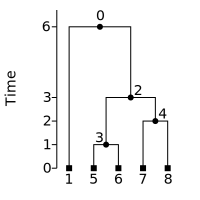

In [18]:
print("Time units are", tree.tree_sequence.time_units)
tree.draw_svg(y_axis=True)

Although branch lengths are not stored explicitly, for convenience `tskit` provides a
{meth}`Tree.branch_length` method:

In [19]:
print(
    "The edge (i.e. branch) immediately above node",
    node_id,
    "has a 'length' of",
    tree.branch_length(node_id),
)

The edge (i.e. branch) immediately above node 4 has a 'length' of 1.0


:::{todo}
The branch distance between two samples is also easy to calculate

NB: Turn the following in to a code cell
```
target_node_1 = 5
target_node_2 = 7
print(
    "The branch distance between nodes",
    target_node_1,
    "and",
    target_node_2,
    "is",
    # See https://github.com/tskit-dev/tskit/issues/2627 - what should be call this
    # so as not to get mixed up with tree.path_length which counts the number of edges
    # tree.branch_distance(target_node_1, target_node_2),
)
```

It is worth noting that this distance is the basis for the "genetic divergence"
between two samples in a tree. For this reason, an equivalent way to carry out the
calculation is to use {meth}`TreeSequence.divergence`, part of the the standard `tskit`
{ref}`sec_stats` framework, setting `mode="branch"` and
`windows="trees"`. This is a more flexible approach, as it allows the distance between
multiple sets of samples in {ref}`sec_phylogen_multiple_trees` to be calculated
efficiently:

NB: Turn the following in to a code cell
```
target_node_1 = 5
target_node_2 = 7
print(
    "Branch distance using built-in stats framework:"
    tree.tree_sequence.divergence(([5], [7]), mode="branch", windows="trees")
)
```

:::


(sec_phylogen_multiroot)=
### Roots and multiroot trees

In `tskit`, {ref}`sec_data_model_tree_roots` of trees are defined with respect to the
sample nodes. In particular, if we move back in time along the tree branches from a
sample, the oldest node that we encounter is defined as a root. The ID of a root can be
obtained using {attr}`Tree.root`:

The root node of the following tree has ID 0


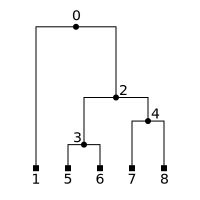

In [20]:
print("The root node of the following tree has ID", tree.root)
tree.draw_svg()

But in `tskit`, we can also create a single "tree" consisting of multiple unlinked
clades. In our example, we can create one of these phylogenetically unusual objects
if we remove the edge above node 4, by
{ref}`editing the underlying tables<sec_tables_editing>`:

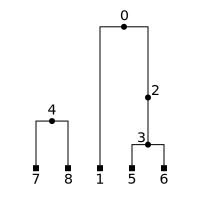

In [21]:
# Trees & tree seqs are immutable: to change them, modify a copy of the underlying tables
tables = ts.dump_tables()
keep_edge = tables.edges.child != 4
tables.edges.replace_with(tables.edges[keep_edge])
new_ts = tables.tree_sequence()  # Turn the edited tables back into a tree sequence
new_tree = new_ts.first()
new_tree.draw_svg()

Although there are two separate topologies in this plot, in `tskit` terminology, it is
considered a single tree, but with two roots:

In [22]:
print("The first tree has", len(new_tree.roots), "roots:", new_tree.roots)

The first tree has 2 roots: [4, 0]


This also means that if we have no topology at all (i.e. an "empty tree"), each
sample is its own root.

This empty tree has 5 roots: [1, 5, 6, 7, 8]


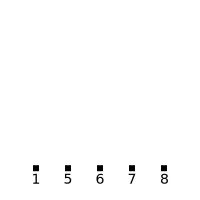

In [23]:
tables.edges.clear()
erased_ts = tables.tree_sequence()
empty_tree = erased_ts.first()
print("This empty tree has", len(empty_tree.roots), "roots:", empty_tree.roots)
empty_tree.draw_svg()

The samples here are {ref}`sec_data_model_tree_isolated_nodes`. This may seem like a
strange corner case, but in `tskit`, isolated sample nodes are used to represent
{ref}`sec_data_model_missing_data`. This therefore represents a tree in which
relationships between the samples are not known. This could apply, for instance,
in regions of the genome where no genetic data exists, or where genetic ancestry
has not been simulated.

(sec_phylogen_methods)=
## Phylogenetic methods

:::{todo}
Demo some phylogenetic methods. e.g.
1. Total branch length - demo quick calculation across multiple trees - incremental algorithm used extensively in population genetics. ("bringing tree thinking to popgen").
2. KC distance
3. Balance metrics
4. Topology rankings (see https://github.com/tskit-dev/tutorials/issues/93)
:::


(sec_phylogen_unified_structure)=
## Storing and accessing genetic data

`Tskit` has been designed to capture both evolutionary tree topologies and the genetic
sequences that evolve along the branches of these trees. This is achieved by defining
{ref}`sec_terminology_mutations_and_sites` which are associated with specific positions
along the genome.

Variable sites with the following IDs generated
Site ID 0 @ genomic position 7: C -> T
Site ID 1 @ genomic position 8: C -> G
Site ID 2 @ genomic position 24: T -> C
Site ID 3 @ genomic position 34: C -> A
Site ID 4 @ genomic position 49: T -> A
Site ID 5 @ genomic position 51: G -> T
Site ID 6 @ genomic position 52: T -> A
Site ID 7 @ genomic position 54: G -> A
Site ID 8 @ genomic position 60: G -> A


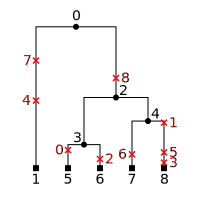

In [24]:
import msprime  # The `msprime` package can throw mutations onto a tree sequence
mutated_ts = msprime.sim_mutations(ts, rate=3e-3, random_seed=321)
mutated_tree = mutated_ts.first()
print("Variable sites with the following IDs generated")
for site in mutated_tree.sites():
    print(
        f"Site ID {site.id} @ genomic position {site.position:g}:",
        f"{site.ancestral_state} -> {site.mutations[0].derived_state}"
    )
mutated_tree.draw_svg()

Mutations occur above nodes in a tree, with all the descendant
nodes inheriting that specific mutation (unless replaced by a subsequent
mutation at the same site). This allows genetic variation to be
{ref}`efficiently represented<sec_what_is_dna_data>` using the tree topology.
To obtain the genetic variation at each site across the entire genome, you can use the
{meth}`TreeSequence.sites` method, or (less efficiently), you can use
{meth}`TreeSequence.alignments` to output the
entire sequences for each sample node:

In [25]:
for node_id, alignment in zip(
    mutated_ts.samples(),
    mutated_ts.alignments(missing_data_character="."),
):
    print(f"Node {node_id}: {alignment}")

Node 1: .......CC...............T.........C..............A.GT.A.....G.......................................
Node 5: .......TC...............T.........C..............T.GT.G.....A.......................................
Node 6: .......CC...............C.........C..............T.GT.G.....A.......................................
Node 7: .......CC...............T.........C..............T.GA.G.....A.......................................
Node 8: .......CG...............T.........A..............T.TT.G.....A.......................................


(sec_phylogen_multiple_trees)=
## Multiple trees

Where `tskit` really shines is when the ancestry of your dataset cannot be adequately
represented by a single tree. This is a pervasive issue in genomes (even from different
species) that have undergone recombination in the past. The resulting series of
{ref}`local trees<sec_what_is_local_trees>` along a genome are highly correlated
(see {ref}`sec_concepts`).

Instead of storing each tree along a genome separately, `tskit` records the genomic
coordinates of each edge, which leads to enormous efficiencies in storage and
analysis. As a basic demonstration, we can repeat the edge removal example
{ref}`above <sec_phylogen_multiroot>`, but only remove the ancestral link above node 4
for the first half of the genome.

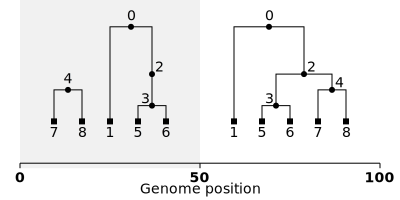

In [26]:
tables = ts.dump_tables()
edge_id_above_node_4 = ts.first().edge(4)
left_coord_for_edges = tables.edges.left
left_coord_for_edges[edge_id_above_node_4] = 50
tables.edges.left = left_coord_for_edges  # reset the right coords
tables.sort()
multi_ts = tables.tree_sequence()

multi_ts.draw_svg()

For the left hand side of the genome we lack information about the ancestry of
node 4, but for the right hand side we know this information. The result is to
generate 2 trees in the tree sequence, which differ only in the presence of absence of
a single branch. We do not have to separately store the entire tree on the right: all
the edges that are shared between trees are stored only once.

The rest of the `tskit` tutorials will lead you through the concepts involved with
storing and analysing sequences of many correlated trees. For a simple introduction, you
might want to start with {ref}`sec_what_is`.